# Predicting Vertical Mixing Shape Functions with Gaussian Features
Vertical mixing in the ocean surface boundary layer (OSBL) is often parameterized using a fixed *“universal”* shape function for the vertical diffusivity profile. However, Second Moment Closure models show that the actual shape of the diffusivity profile can vary significantly with forcing conditions. 

We seek to use neural networks to predict these variable shape functions, building on the work of Sane et al. (2023). In particular, we implement two modeling strategies using PyTorch:

---

### 1. **Direct shape prediction with Gaussian feature layer**
- Transform the input physical parameters through a Gaussian radial-basis function (RBF) layer
- Have the network output the 16 discrete values of the shape function profile directly (at fixed vertical levels)

---

### 2. **Gaussian Mixture Model (GMM) output**
- Have the network predict parameters of a Gaussian mixture (means, standard deviations, amplitudes)
- Reconstruct the shape function as a sum of Gaussians over the vertical coordinate

---

### Inputs and Training Details

Both models use the following inputs (consistent with Sane et al., 2023):
- Coriolis parameter *f*
- Surface buoyancy flux *B₀*
- Friction velocity *uₐ*
- Boundary layer depth *h*

To ensure predicted diffusivity profiles remain non-negative, we predict the **logarithm** of the shape function, `log g(σ)`, rather than `g(σ)` itself.

We train the networks on data generated by a high-resolution 1-D turbulence model (e.g., GOTM in Sane et al., 2023) that provides “SMC-based” shape functions.

---

### Loss and Regularization
- Model training uses **mean absolute error (L1 loss)**, which outperformed L2 (RMSE) for this problem.
- We also employ **early stopping** based on validation loss to prevent overfitting.

In [2]:
import numpy as np
import xarray as xr

# Open the dataset from Sane et al. 2023, stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'

# Load the dataset
ds = xr.open_dataset(store, engine='zarr')


X = np.column_stack([
    ds['b0'].values,   
    ds['h'].values,    
    ds['ustar'].values,
    ds['lat'].values   
])


y = ds['SF'].values

N_total = len(X)
N_train = int(0.6 * N_total)
N_val = int(0.2 * N_total)
N_test = N_total - N_train - N_val

X_train = X[:N_train]
X_val = X[N_train:N_train+N_val]
X_test = X[N_train+N_val:]

y_train = y[:N_train]
y_val = y[N_train:N_train+N_val]
y_test = y[N_train+N_val:]

y_train_log = np.log(np.maximum(y_train, 1e-10))  # 避免log(0)
mean_log = y_train_log.mean(axis=0)
std_log = y_train_log.std(axis=0)
y_train_norm = (y_train_log - mean_log) / std_log

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_norm = (X_train - X_mean) / X_std

X_val_norm = (X_val - X_mean) / X_std
y_val_log = np.log(np.maximum(y_val, 1e-10))
y_val_norm = (y_val_log - mean_log) / std_log

X_test_norm = (X_test - X_mean) / X_std
y_test_log = np.log(np.maximum(y_test, 1e-10))
y_test_norm = (y_test_log - mean_log) / std_log

## Model Variant 1: RBF Neural Network (Gaussian Features)


**Architecture:**  
The first model uses a radial basis function (RBF) layer to transform the input features into a higher-dimensional feature space before prediction.

An RBF layer consists of a set of Gaussian “basis” functions:  

$$
\phi_i = \exp\left(-\frac{||x - \mu_i||^2}{2\sigma_i^2}\right)
$$

where:  
- $\mu_i$ is the center of the *i*-th Gaussian in input space  
- $\sigma_i$ is its width  

By using RBF features, the network can more easily capture nonlinear interactions between the inputs in a smooth way.  
We then use a linear layer to map these RBF features to the 16 outputs (corresponding to $\log g$ at the 16 depth points).

---

**Implementation details:**  
- We choose a certain number of RBF centers (e.g., 50) and initialize their centers ($\mu_i$) using representative points from the training data (e.g., via clustering or random sampling).  
- We fix the RBF widths $\sigma_i$ (or treat them as learnable parameters).  
- For simplicity, we use **isotropic Gaussians** with either a constant width or one width per center.  
- The output layer is **linear** (no activation), because we want it to produce **real values** (which correspond to normalized log-shape values).

In [4]:
!pip install torch
import torch
import torch.nn as nn

class RBFShapeNet(nn.Module):
    def __init__(self, input_dim, num_centers, output_dim, centers, widths):
        super().__init__()
        # Register the RBF centers and widths as buffers (non-trainable tensors)
        self.register_buffer('centers', torch.tensor(centers, dtype=torch.float32))
        self.register_buffer('widths',  torch.tensor(widths, dtype=torch.float32))
        # Linear layer to map RBF features to 16 outputs (log(g) values)
        self.out_layer = nn.Linear(num_centers, output_dim)
    
    def forward(self, x):
        # x: shape (batch_size, input_dim), normalized inputs
        # Compute squared distance of x to each center (broadcasting)
        # centers: (num_centers, input_dim)
        diff = x.unsqueeze(1) - self.centers.unsqueeze(0)   # (batch, num_centers, input_dim)
        dist_sq = torch.sum(diff**2, dim=-1)                # (batch, num_centers)
        # Compute RBF activations: exp(-dist^2 / (2σ^2))
        phi = torch.exp(-dist_sq / (2 * (self.widths**2)))
        # Linear combination of RBF features to get outputs
        out = self.out_layer(phi)  # (batch, 16)
        return out

# Initialize RBF centers and widths (e.g., using 50 random training samples as centers)
num_centers = 50
idx = np.random.choice(len(X_train_norm), num_centers, replace=False)
centers_init = X_train_norm[idx]                 # shape (50, 4)
widths_init = np.full(num_centers, 1.0)          # e.g. use width=1.0 for all, or tune as needed

# Instantiate the model
input_dim = X_train_norm.shape[1]   # 4
output_dim = y_train_norm.shape[1]  # 16
model_rbf = RBFShapeNet(input_dim, num_centers, output_dim, centers_init, widths_init)
print(model_rbf)

RBFShapeNet(
  (out_layer): Linear(in_features=50, out_features=16, bias=True)
)


## Model Variant 2: Gaussian Mixture Network

**Architecture:**  
The second model outputs a *parameterized functional representation* of the shape profile instead of predicting each value independently.

Specifically, the network will output the parameters of a Gaussian Mixture Model (GMM): a set of $K$ Gaussian components whose sum defines the shape function.

For example, with $K = 3$, the network will output:
- 3 means: $\mu_1$, $\mu_2$, $\mu_3$  
- 3 standard deviations: $\sigma_1$, $\sigma_2$, $\sigma_3$  
- 3 amplitudes: $A_1$, $A_2$, $A_3$  

The shape function is then reconstructed as:

$$
g(\sigma) = \sum_{k=1}^{K} A_k \exp\left( -\frac{(\sigma - \mu_k)^2}{2\sigma_k^2} \right)
$$

for $\sigma \in [0, 1]$ (the normalized depth).  

This ensures $g(\sigma)$ is always **positive** (since each Gaussian component is positive) and **smooth**.

By adjusting the Gaussian parameters, the network can represent a variety of profile shapes with a relatively small number of parameters  
(e.g., 9 parameters for 3 Gaussians, instead of 16 independent values).  

This approach adds physical structure to the output and can improve generalization by restricting outputs to plausible smooth shapes.

---

**Implementation details:**  
- We use a standard feed-forward network to map the inputs to the Gaussian parameters.  
- The output layer has $3K$ units, which we split into means, standard deviations, and amplitudes.  
- We apply appropriate **activations** to enforce constraints:
  - A **sigmoid** to map raw mean outputs to $(0,1)$ (since $\sigma$ is normalized depth),
  - A **softplus** to ensure standard deviations are positive,
  - A **softplus** for amplitudes (to ensure positivity).  
- We then reconstruct the shape profile at the 16 discrete $\sigma$ points.  
- During training, we compare this reconstructed (log) profile to the target profile.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GMMShapeNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_components):
        super().__init__()
        self.num_components = num_components
        # Two hidden layers (fully connected)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Output layer: predicts 3 * num_components parameters
        self.fc_out = nn.Linear(hidden_dim, 3 * num_components)
    
    def forward(self, x):
        # x: (batch_size, input_dim) normalized inputs
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        params = self.fc_out(h)  # shape (batch, 3*K)
        K = self.num_components
        mean_raw = params[:, 0:K]
        std_raw  = params[:, K:2*K]
        amp_raw  = params[:, 2*K:3*K]
        
        # Apply constraints
        means = torch.sigmoid(mean_raw)        # in (0,1)
        stds  = F.softplus(std_raw) + 1e-6      # >0
        amps  = F.softplus(amp_raw)             # >0
        
        # Sigma points as tensor (assumes global variable sigma_points exists)
        sigma = torch.tensor(sigma_points, dtype=torch.float32, device=x.device)
        
        # Compute Gaussians
        diff = sigma.unsqueeze(0).unsqueeze(0) - means.unsqueeze(2)  # (batch, K, 16)
        gauss = torch.exp(-0.5 * (diff / stds.unsqueeze(2)) ** 2)    # (batch, K, 16)
        weighted = amps.unsqueeze(2) * gauss                         # (batch, K, 16)
        g_sigma = torch.sum(weighted, dim=1)                         # (batch, 16)
        
        # Log and normalize
        log_g = torch.log(g_sigma + 1e-10)
        log_g_norm = (log_g - torch.tensor(mean_log, device=x.device)) / torch.tensor(std_log, device=x.device)
        return log_g_norm

model_gmm = GMMShapeNet(input_dim=4, hidden_dim=64, num_components=3)
print(model_gmm)

GMMShapeNet(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=9, bias=True)
)


## Training the Models with Early Stopping

We train both models to minimize the **L1 loss** between the predicted and true log-shape profiles.  
We use **early stopping** on a validation set to avoid overfitting.  

Early stopping will monitor the validation loss and stop training if it hasn’t improved for a certain number of epochs (*patience*).  
We also save the model weights corresponding to the best validation loss.

---

### Training procedure:

1. **Initialization**:  
   Initialize model parameters (e.g., using PyTorch defaults) and optimizer (e.g., Adam).

2. **Mini-batch training**:  
   Loop over epochs, and in each epoch loop over mini-batches of the training data:
   - Compute the model output for the batch.  
   - Compute the loss (L1 between predicted and target log-*g* profiles).  
   - Backpropagate and update weights.

3. **Validation**:  
   At the end of each epoch, evaluate the model on the validation set (compute val loss but **do not** update weights).

4. **Early stopping check**:  
   If the validation loss is the lowest seen so far, save the model state.  
   If it hasn’t improved for *patience* epochs, stop training.

5. **Load best model**:  
   After stopping, load the saved best model parameters for evaluation.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GMMShapeNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_components, sigma_points=None):
        super().__init__()
        self.num_components = num_components
        
        # If sigma_points is not provided, create default
        if sigma_points is None:
            sigma_points = np.linspace(0, 1, 18)[1:-1]
        
        # Register sigma_points as a buffer
        self.register_buffer('sigma_points', torch.tensor(sigma_points, dtype=torch.float32))
        
        # Two hidden layers (fully connected)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Output layer: predicts 3 * num_components parameters
        self.fc_out = nn.Linear(hidden_dim, 3 * num_components)
    
    def forward(self, x):
        # x: (batch_size, input_dim) normalized inputs
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        params = self.fc_out(h)  # shape (batch, 3*K)
        K = self.num_components
        mean_raw = params[:, 0:K]
        std_raw  = params[:, K:2*K]
        amp_raw  = params[:, 2*K:3*K]
        
        # Apply constraints
        means = torch.sigmoid(mean_raw)        # in (0,1)
        stds  = F.softplus(std_raw) + 1e-6     # >0
        amps  = F.softplus(amp_raw)            # >0
        
        # Use registered sigma points
        sigma = self.sigma_points
        
        # Compute Gaussians
        diff = sigma.unsqueeze(0).unsqueeze(0) - means.unsqueeze(2)  # (batch, K, 16)
        gauss = torch.exp(-0.5 * (diff / stds.unsqueeze(2)) ** 2)    # (batch, K, 16)
        weighted = amps.unsqueeze(2) * gauss                         # (batch, K, 16)
        g_sigma = torch.sum(weighted, dim=1)                         # (batch, 16)
        
        # Log and normalize
        log_g = torch.log(g_sigma + 1e-10)
        
        # Assuming mean_log and std_log are available globally
        log_g_norm = (log_g - torch.tensor(mean_log, device=x.device)) / torch.tensor(std_log, device=x.device)
        return log_g_norm

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=64, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.L1Loss()  # L1 loss (MAE) on normalized log(g)
    
    # Convert to tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0
    
    for epoch in range(1, epochs+1):
        model.train()
        # Shuffle training data indices
        perm = torch.randperm(X_train_t.size(0))
        batch_losses = []
        
        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            x_batch = X_train_t[idx]
            y_batch = y_train_t[idx]
            
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # Compute average training loss for this epoch
        train_loss = np.mean(batch_losses)
        
        # Validation loss
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = loss_fn(val_pred, y_val_t).item()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()  # save best model parameters
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % 10 == 0 or patience_counter == 0:
            print(f"Epoch {epoch}: Train loss={train_loss:.4f}, Val loss={val_loss:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement in {patience} epochs).")
            break
    
    # Load best model weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

# Create models
model_rbf = RBFShapeNet(input_dim=X_train_norm.shape[1], 
                        num_centers=50, 
                        output_dim=y_train_norm.shape[1], 
                        centers=centers_init, 
                        widths=widths_init)

model_gmm = GMMShapeNet(input_dim=X_train_norm.shape[1], 
                        hidden_dim=64, 
                        num_components=3)

# Train models
model_rbf = train_model(model_rbf, X_train_norm, y_train_norm, X_val_norm, y_val_norm, epochs=100, patience=10)
model_gmm = train_model(model_gmm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, epochs=100, patience=10)

Epoch 1: Train loss=0.3072, Val loss=0.4278
Epoch 2: Train loss=0.2741, Val loss=0.4152
Epoch 3: Train loss=0.2684, Val loss=0.4100
Epoch 5: Train loss=0.2629, Val loss=0.4078
Epoch 8: Train loss=0.2590, Val loss=0.4064
Epoch 10: Train loss=0.2573, Val loss=0.4107
Early stopping at epoch 18 (no improvement in 10 epochs).
Epoch 1: Train loss=0.1814, Val loss=0.1435
Epoch 2: Train loss=0.1492, Val loss=0.1174
Epoch 3: Train loss=0.1444, Val loss=0.1101
Epoch 4: Train loss=0.1415, Val loss=0.1064
Epoch 6: Train loss=0.1383, Val loss=0.1024
Epoch 7: Train loss=0.1373, Val loss=0.1023
Epoch 10: Train loss=0.1355, Val loss=0.1091
Epoch 12: Train loss=0.1347, Val loss=0.0986
Epoch 20: Train loss=0.1325, Val loss=0.1006
Early stopping at epoch 22 (no improvement in 10 epochs).


## Model Evaluation and Results

In [10]:
import numpy as np

# Assume X_test_norm, y_test_norm are prepared, and model is trained
model_rbf.eval()
with torch.no_grad():
    pred_test_rbf = model_rbf(torch.tensor(X_test_norm, dtype=torch.float32)).cpu().numpy()
model_gmm.eval()
with torch.no_grad():
    pred_test_gmm = model_gmm(torch.tensor(X_test_norm, dtype=torch.float32)).cpu().numpy()

# Invert normalization for evaluation (to get actual log(g) values)
pred_log_rbf = pred_test_rbf * std_log + mean_log
pred_log_gmm = pred_test_gmm * std_log + mean_log
y_test_log   = np.log(y_test)  # true log(g) on test
# Convert log back to g(sigma) for intuition (though metrics can be on log scale too)
pred_g_rbf = np.exp(pred_log_rbf)
pred_g_gmm = np.exp(pred_log_gmm)
true_g     = y_test

# Compute MAE and RMSE in physical space
mae_rbf  = np.mean(np.abs(pred_g_rbf - true_g))
rmse_rbf = np.sqrt(np.mean((pred_g_rbf - true_g)**2))
mae_gmm  = np.mean(np.abs(pred_g_gmm - true_g))
rmse_gmm = np.sqrt(np.mean((pred_g_gmm - true_g)**2))
print(f"RBF Model – MAE: {mae_rbf:.4f}, RMSE: {rmse_rbf:.4f}")
print(f"GMM Model – MAE: {mae_gmm:.4f}, RMSE: {rmse_gmm:.4f}")

# Compute weighted-average correlation
def weighted_correlation(pred_profiles, true_profiles):
    # pred_profiles, true_profiles: arrays of shape (n_samples, 16)
    correlations = []
    weights = []
    for j in range(true_profiles.shape[1]):  # for each depth level
        pj = pred_profiles[:, j]
        tj = true_profiles[:, j]
        # Pearson correlation at level j
        corr = np.corrcoef(pj, tj)[0,1]
        correlations.append(corr)
        weights.append(np.mean(true_profiles[:, j]))  # weight by mean true g at this level
    correlations = np.array(correlations)
    weights = np.array(weights)
    # Weighted average
    return np.sum(correlations * weights) / np.sum(weights)

wcorr_rbf = weighted_correlation(pred_g_rbf, true_g)
wcorr_gmm = weighted_correlation(pred_g_gmm, true_g)
print(f"Weighted correlation – RBF: {wcorr_rbf:.3f}, GMM: {wcorr_gmm:.3f}")

RBF Model – MAE: 0.1089, RMSE: 0.1438
GMM Model – MAE: 0.0192, RMSE: 0.0302
Weighted correlation – RBF: 0.552, GMM: 0.985


## Visualization

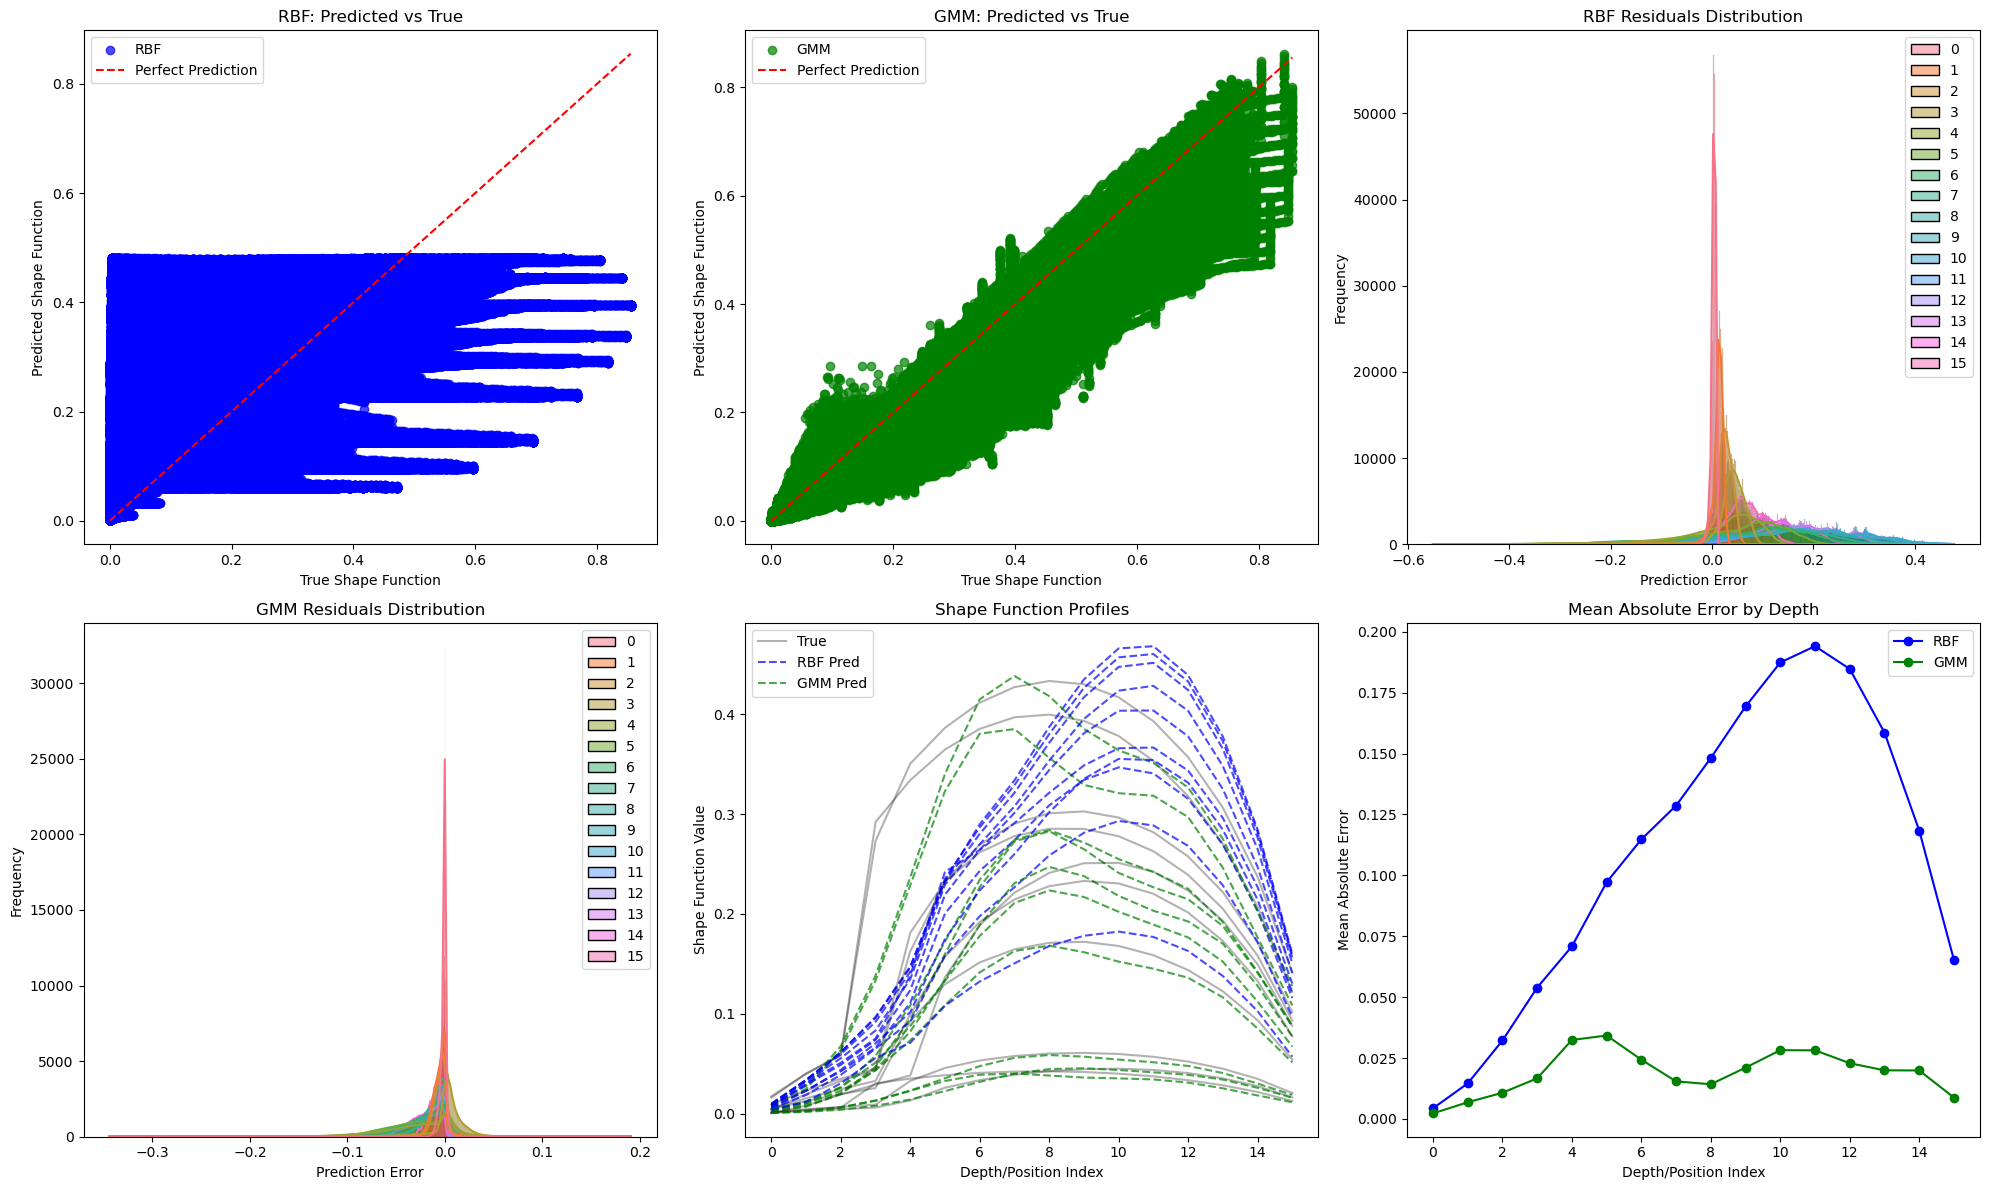

/var/folders/t1/r8kxbd0s0xg_vgsb9yh3xhd40000gn/T/ipykernel_38397/596203877.py:127: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


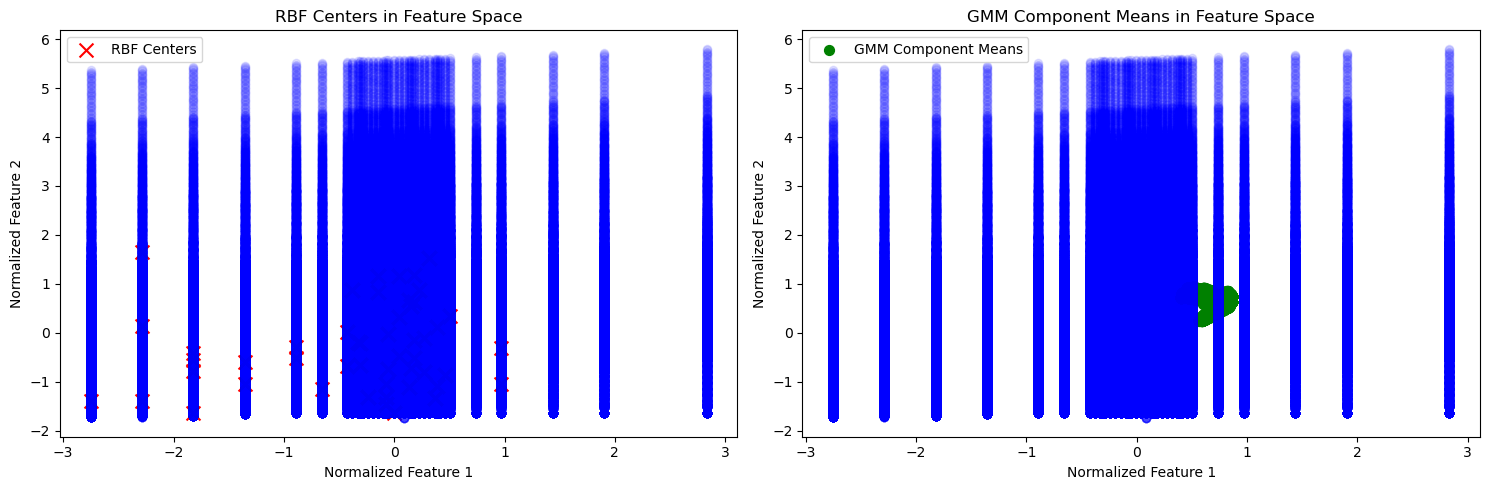

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns

def visualize_model_performance(X_test_norm, y_test, pred_g_rbf, pred_g_gmm, 
                                mean_log, std_log, title_prefix=''):
    """
    Comprehensive visualization of RBF and GMM model predictions
    
    Parameters:
    - X_test_norm: Normalized test input features
    - y_test: True shape function values
    - pred_g_rbf: RBF model predictions
    - pred_g_gmm: GMM model predictions
    - mean_log: Mean of log-transformed training data
    - std_log: Standard deviation of log-transformed training data
    - title_prefix: Optional prefix for plot titles
    """
    plt.figure(figsize=(20, 12))
    
    # 1. Scatter plot of predicted vs true values for both models
    plt.subplot(2, 3, 1)
    plt.scatter(y_test, pred_g_rbf, label='RBF', alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', label='Perfect Prediction')
    plt.title(f'{title_prefix}RBF: Predicted vs True')
    plt.xlabel('True Shape Function')
    plt.ylabel('Predicted Shape Function')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.scatter(y_test, pred_g_gmm, label='GMM', alpha=0.7, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', label='Perfect Prediction')
    plt.title(f'{title_prefix}GMM: Predicted vs True')
    plt.xlabel('True Shape Function')
    plt.ylabel('Predicted Shape Function')
    plt.legend()
    
    # 2. Residual plots
    plt.subplot(2, 3, 3)
    residuals_rbf = pred_g_rbf - y_test
    sns.histplot(residuals_rbf, kde=True, color='blue')
    plt.title(f'{title_prefix}RBF Residuals Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')

    plt.subplot(2, 3, 4)
    residuals_gmm = pred_g_gmm - y_test
    sns.histplot(residuals_gmm, kde=True, color='green')
    plt.title(f'{title_prefix}GMM Residuals Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    
    # 3. Profile Comparison
    plt.subplot(2, 3, 5)
    # Random selection of 10 samples to show profile comparison
    indices = np.random.choice(len(y_test), 10, replace=False)
    for idx in indices:
        plt.plot(range(len(y_test[idx])), y_test[idx], 'k-', alpha=0.3)
        plt.plot(range(len(y_test[idx])), pred_g_rbf[idx], 'b--', alpha=0.7)
        plt.plot(range(len(y_test[idx])), pred_g_gmm[idx], 'g--', alpha=0.7)
    plt.title(f'{title_prefix}Shape Function Profiles')
    plt.xlabel('Depth/Position Index')
    plt.ylabel('Shape Function Value')
    plt.legend(['True', 'RBF Pred', 'GMM Pred'])
    
    # 4. Depth-wise Error Visualization
    plt.subplot(2, 3, 6)
    depth_errors_rbf = np.abs(pred_g_rbf - y_test).mean(axis=0)
    depth_errors_gmm = np.abs(pred_g_gmm - y_test).mean(axis=0)
    plt.plot(depth_errors_rbf, label='RBF', marker='o', color='blue')
    plt.plot(depth_errors_gmm, label='GMM', marker='o', color='green')
    plt.title(f'{title_prefix}Mean Absolute Error by Depth')
    plt.xlabel('Depth/Position Index')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Visualization function for model architecture and centers/components
def visualize_model_architecture(model_rbf, model_gmm, X_train_norm):
    """
    Visualize RBF centers and GMM components
    
    Parameters:
    - model_rbf: Trained RBF model
    - model_gmm: Trained GMM model
    - X_train_norm: Normalized training input features
    """
    plt.figure(figsize=(15, 5))
    
    # RBF Centers Visualization
    plt.subplot(1, 2, 1)
    centers = model_rbf.centers.cpu().numpy()
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='RBF Centers')
    plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], alpha=0.1, c='blue')
    plt.title('RBF Centers in Feature Space')
    plt.xlabel('Normalized Feature 1')
    plt.ylabel('Normalized Feature 2')
    plt.legend()
    
    # GMM Components Visualization
    plt.subplot(1, 2, 2)
    # Extract GMM parameters
    with torch.no_grad():
        params = model_gmm.fc_out(torch.relu(model_gmm.fc2(torch.relu(model_gmm.fc1(torch.tensor(X_train_norm, dtype=torch.float32))))))
    
    K = model_gmm.num_components
    mean_raw = params[:, 0:K].numpy()
    std_raw = params[:, K:2*K].numpy()
    amp_raw = params[:, 2*K:3*K].numpy()
    
    means = 1 / (1 + np.exp(-mean_raw))  # sigmoid
    stds = np.log(1 + np.exp(std_raw)) + 1e-6  # softplus
    amps = np.log(1 + np.exp(amp_raw))  # softplus
    
    plt.scatter(means[:, 0], means[:, 1], c='green', marker='o', s=50, label='GMM Component Means')
    plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], alpha=0.1, c='blue')
    plt.title('GMM Component Means in Feature Space')
    plt.xlabel('Normalized Feature 1')
    plt.ylabel('Normalized Feature 2')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Main visualization call (ensure all required variables are in scope)
visualize_model_performance(X_test_norm, true_g, pred_g_rbf, pred_g_gmm, 
                            mean_log, std_log)
visualize_model_architecture(model_rbf, model_gmm, X_train_norm)